In [63]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from scipy import stats
from scipy import constants
from mpl_toolkits.axes_grid1 import make_axes_locatable
import types
from sklearn.model_selection import train_test_split

In [53]:
def rsq(x, x_src, b_src):
    # include finite size of sensor to avoid divide by 0 when scanning (x, b)
    return (x_src-x)**2 + b_src**2 + 0.05**2

#arrival time is normal distribution
arrival_time = lambda t: stats.norm(loc=t, scale=1)
c = constants.c*1e-9 # m/ns

#number of observed hits is poisson distribution
obs_hits = lambda N: stats.poisson(mu=N)

detector_loc = lambda n: np.linspace(-5,5,n)

x_toy = 2.45
b_toy = 1.1
N_toy = 2.3
N_det = 11

In [48]:
def generate_event(x_src, b=1, N_src=10, t_src=0, N_det=11):
    '''
    generates event
    
    Parameters:
    
    x_rsc : float
        Source position
    t_src : float
        Source time
    N_src : int
        Amount of photons sent out
    b : float
        perpendicaulr distance off of sensor line
    N_det : int
        Number of detectors/sensors
        
    Returns:
    
    Ns : list
        observed number of photons per detector
    ts : list
        observed photon times and detector index
    '''
    Ns = []
    ts = []
    t_idx = []
    for i,x in enumerate(detector_loc(N_det)):
        r2 = rsq(x,x_src,b)
        N_exp = N_src/r2
        N_obs = obs_hits(N_exp).rvs()
        Ns.append(N_obs)
        if N_obs > 0:
            t = arrival_time(t_src + np.sqrt(r2)/c).rvs(size=N_obs)
            ts.extend(t)
            t_idx.extend([i]*N_obs)
    return np.array(Ns), np.array([ts,t_idx]).T

In [49]:
def generate_expectations(x_src, b=1, N_src=10, t_src=0, N_det=11):
    '''
    generates expected values (mean of distributions)
    
    Parameters:
    
    x_rsc : float
        Source position
    t_src : float
        Source time
    N_src : int
        Amount of photons sent out
    b : float
        perpendicaulr distance off of sensor line
    N_det : int
        Number of detectors/sensors
        
    Returns:
    
    Ns : list
        expected number of photons per detector
    ts : list
        expected pulse times
    '''
    Ns = []
    ts = []
    for x in detector_loc(N_det):
        r2 = rsq(x,x_src,b)
        N_exp = N_src/r2
        Ns.append(N_exp)
        t = t_src + np.sqrt(r2)/c
        ts.append(t)
    return Ns, ts

In [50]:
def plot_event(Ns, ts, x_src, b=1, N_src=10, t_src=0, N_det=11):
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    plt.subplots_adjust(hspace=0.4)
    
    flat_axes = axes.flat
    
    ax = next(flat_axes)
    
    ax.set_title('hit times')
    ax.set_xlabel('t (ns)')
    
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    det_xs = detector_loc(N_det)
    
    for i, x_det in enumerate(det_xs):
        #expectation
        r2 = rsq(x_det,x_src,b)
        t_dist = arrival_time(t_src + np.sqrt(r2)/c)
        mu = t_dist.mean()
        std = t_dist.std()
        times = np.linspace(mu - 3*std, mu + 3*std, 1000)
        ax.plot(times, t_dist.pdf(times))
        
        #measured
        sensor_times = ts[ts[:,1] == i][:,0]
        if len(sensor_times) > 0:
            ax.bar(sensor_times, [0.25]*len(sensor_times), width=0.1, alpha=0.5,
                  color=color_cycle[i % len(color_cycle)])

    ax.set_yticklabels([])
    
    ax = next(flat_axes)
    for i, N in enumerate(Ns):
        ax.bar([det_xs[i]], [N], label=f'x={det_xs[i]:.0f} m')
    
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.75))
        
    r2 = rsq(det_xs,x_src,b)
    N_exp = N_src/r2
    plt_xs = [det_xs[0] - 1] + list(det_xs) + [det_xs[-1] + 1]
    plt_ys = [0] + list(N_exp) + [0]
    ax.step(plt_xs, plt_ys, 'k--', where='mid', label='expected')
        
    ax.set_xlim(det_xs[0]-0.5, det_xs[-1] + 0.5)
        
    ax.set_yscale('log')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('$Q_d$')
    ax.set_title('pulses per sensor')

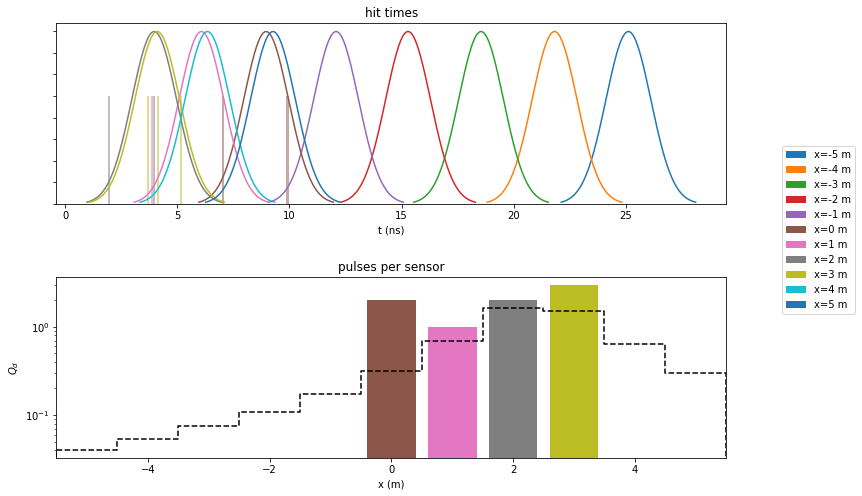

In [18]:
ev = generate_event(x_toy,b=b_toy,N_src=N_toy)
plot_event(*ev,x_toy,b=b_toy,N_src=N_toy)

In [51]:
#log-likelihoods

def hit_pdf(ts, x_src, b=1, t_src=0, N_det=11):
    x_det = detector_loc(N_det)
    r2 = rsq(x_det,x_src,b)
    t_exp = t_src + np.sqrt(r2)/c
    
    t_std = 1.
    # t_std could in principle vary with the hypothesis, even though it doesn't in this example
    llh = 0
   
    for hit in ts:
        t_det = hit[0]
        i = int(hit[1])
        llh += -(t_det-t_exp[i])**2/(2*t_std**2) - np.log(t_std) ##was originally +log?
    
    return llh

def charge_pdf(Ns, x_src, b=1, N_src=10, N_det=11):
    x_det = detector_loc(N_det)
    r2 = rsq(x_det,x_src,b)
    N_exp = N_src/r2
    
    return (Ns*np.log(N_exp) - N_exp).sum()

In [20]:
def llh_scan(Ns, ts, param_table, N_det=11):
    '''
    the columns of param_table shall be ordered as follows:
    hypo_xs, hypo_bs, hypo_ts, hypo_n_srcs
    
    Returns:
    
    dom_hit_terms: np.array
    
    dom_charge_terms: np.array

    '''
    n_params = len(param_table)
    
    dom_hit_terms = np.empty(n_params)
    dom_charge_terms = np.empty(n_params)
    
    # store -llhs, multiply everything by -1
    for i in range(param_table.shape[0]):
        hypo_x, hypo_b, hypo_t, hypo_N_src = param_table[i, :]
    
        dom_hit_terms[i] = -hit_pdf(ts, hypo_x, b=hypo_b, t_src=hypo_t, N_det=N_det)
    
        dom_charge_terms[i] = -charge_pdf(Ns, hypo_x, b=hypo_b, N_src=hypo_N_src, N_det=N_det)
        
    return dom_hit_terms, dom_charge_terms

In [21]:
def map_2d(Ns, ts, inds, steps, base_x, base_b=1, base_t=0, base_N=10, N_det=11):
           
    mg = np.meshgrid(*steps)
           
    n_hypotheses = mg[0].size
    
    base_params = np.array([base_x,base_b,base_t,base_N])
    param_table = np.repeat(base_params[np.newaxis, :], n_hypotheses, axis=0)

    for ind, coord in zip(inds, mg):
        param_table[:, ind] = coord.flat
           
    return llh_scan(Ns, ts, param_table, N_det=N_det)

In [22]:
def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    #from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    cbar.ax.tick_params(labelsize=12)
    return cbar

def plot_scan(llh_scan_res, xs, ys, true_x, true_y, axis_labels, vmaxes):
    # copy to avoid modifying original scan results
    dom_hits, dom_charge = np.copy(llh_scan_res)
    
    dom_terms = dom_hits, dom_charge
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    plt.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(wspace=0.5)
    
    gridsize = len(xs)
    
    flat_axes = axes.flat

    ax = next(flat_axes)
        
    # subtract minimum value from each scan result
    for term in dom_terms:
        term[:] -= term.min()
        
    m = ax.pcolormesh(xs, ys, dom_terms[0].reshape(gridsize, gridsize), 
                          cmap='Spectral', rasterized=True, linewidth=0, vmin=0, vmax=vmaxes[0])
        
    ax.plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
        
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    ax.set_title(f'DOM hit term (Gaussian)')
    colorbar(m)
        
    ax = next(flat_axes)
    m = ax.pcolormesh(xs, ys, dom_terms[1].reshape(gridsize, gridsize), 
                          cmap='Spectral', rasterized=True, linewidth=0, vmin=0, vmax=vmaxes[1])
    ax.plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
        
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    ax.set_title(f'DOM charge term (Poisson)')
    colorbar(m)
        
    ax = next(flat_axes)
    sum_term = dom_terms[0]+dom_terms[1]
    sum_term = sum_term - sum_term.min()
    m = ax.pcolormesh(xs, ys, sum_term.reshape(gridsize, gridsize), 
                          cmap='Spectral', rasterized=True, linewidth=0, vmin=0, vmax=vmaxes[2])
    ax.plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
        
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    ax.set_title(f'DOM combined llh')
    colorbar(m)

In [27]:
grid_spacing = 400


xs = np.linspace(-5.5, 5.5, grid_spacing)
bs = np.linspace(-2, 2, grid_spacing)

llh_pos_scan_res = map_2d(*ev, (0, 1), (xs, bs),x_toy,base_b=b_toy,base_N=N_toy)

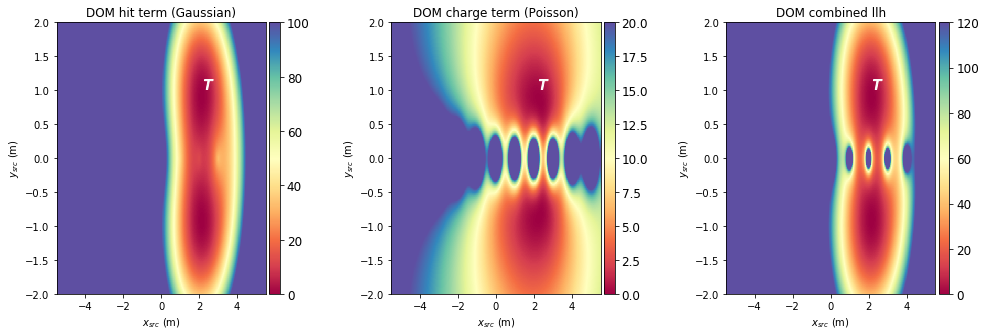

In [28]:
plot_scan(llh_pos_scan_res, xs, bs, x_toy, b_toy,
                   axis_labels=['$x_{src}$ (m)', '$y_{src}$ (m)'], vmaxes=[100, 20, 120])

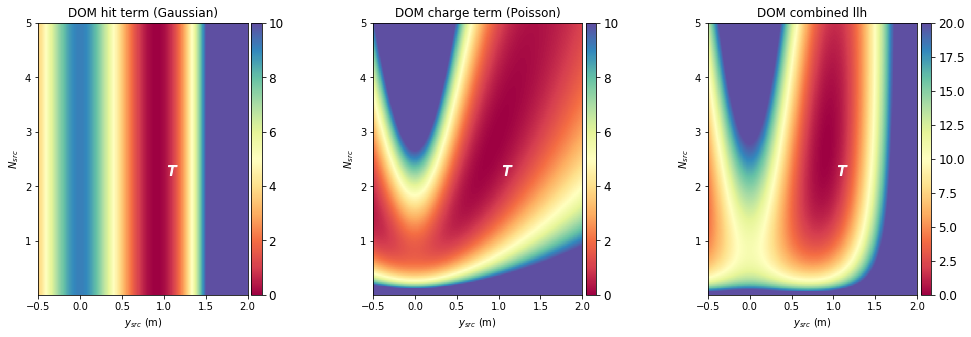

In [29]:
#b and energy
N_srcs = np.linspace(0.01, 5, grid_spacing)
N_srcs_bs = np.linspace(-0.5, 2, grid_spacing)

E_b_scan_res = map_2d(*ev, (1, 3), (N_srcs_bs, N_srcs), x_toy,base_b=b_toy,base_N=N_toy)

plot_scan(E_b_scan_res, N_srcs_bs, N_srcs, b_toy, N_toy,
                   axis_labels=['$y_{src}$ (m)', '$N_{src}$'], vmaxes=[10, 10, 20])

In [31]:
#toy MC
def MC_events(N_events, xlims=(-5, 5), blims=(-2,2), N_lims=(1,20), N_det=11):
    '''
    sample source parameters from uniform distribution of x, b, and N
    and generate events using those.
    N_events : int
        number of desired events
    *_lims : tuple
        lower and upper bount of the uniform to sample from
    N_det: int
        number of detectors in (-5,5)
    Returns:
    events : list of generated events
    truth : true parameters
    '''

    # truth array x, b, N

    x = np.random.uniform(*xlims, N_events)
    b = np.random.uniform(*blims, N_events)
    N = np.random.uniform(*N_lims, N_events)

    truth = np.vstack([x, b, N]).T

    events = []

    for i in range(N_events):
        events.append(generate_event(x[i], b=b[i], N_src=N[i], N_det=N_det))

    return events, truth

In [54]:
mc, truth = MC_events(int(1e5), N_lims=(0, 20))

In [205]:
#neural nets

hitnet = types.SimpleNamespace() #times
chargenet = types.SimpleNamespace() #number of hits

chargenet.events = []
hitnet.events = []
n_hits_per_event = []
for item in mc:
    chargenet.events.append(item[0])
    hitnet.events.append(item[1])
    n_hits_per_event.append(item[1].shape[0])

#chargenet.events = np.array(chargenet.events)
hitnet.events = np.concatenate(hitnet.events)
n_hits_per_event = np.array(n_hits_per_event)

#chargenet.truth = np.array(truth)
hitnet.truth = np.repeat(truth, n_hits_per_event, axis=0)

#assert chargenet.events.shape[0] == chargenet.truth.shape[0]
assert hitnet.events.shape[0] == hitnet.truth.shape[0]

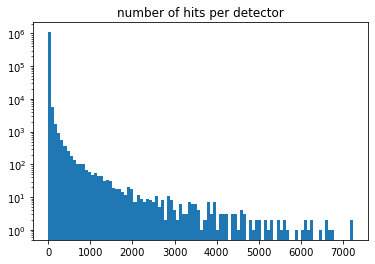

In [56]:
plt.hist(chargenet.events.flatten(), bins=100)
plt.gca().set_yscale('log')
plt.title('number of hits per detector')
plt.show()

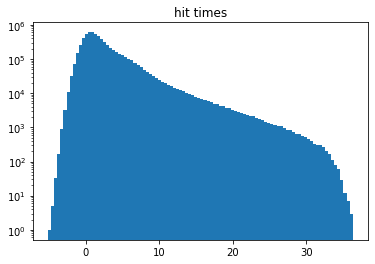

In [57]:
plt.hist(hitnet.events[:,0], bins=100)
plt.gca().set_yscale('log')
plt.title('hit times')
plt.show()

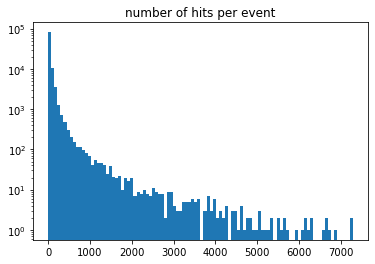

In [58]:
plt.hist(n_hits_per_event, bins=100)
plt.gca().set_yscale('log')
plt.title('number of hits per event')
plt.show()

In [206]:
chargenet.events = np.concatenate(chargenet.events)

chargenet.truth = np.repeat(truth, N_det, axis=0)

In [207]:
chargenet.events = np.vstack((chargenet.events,np.tile(detector_loc(N_det),100000))).T#,np.tile(np.arange(11),100000))).T

In [62]:
def make_dataset(x, t, shuffle_block_size=2**15, batch_size=2**12):
        '''
        get a tensorflow dataset for likelihood approximation
        
        Parameters:
        -----------
        x : ndarray
            observations
        t : ndarray
            parameters        
        shuffle_block_size : int
            block size over which to shuffle, should be multiple of batch_size
        batch_size : int
        
        Returns:
        --------
        
        tf.data.Dataset
            with structure ((x, t), y) for training
        
        '''
        
        N = x.shape[0]
        assert t.shape[0] == N
        
        d_x = tf.data.Dataset.from_tensor_slices(x)
        d_t = tf.data.Dataset.from_tensor_slices(t)

        d_true_labels = tf.data.Dataset.from_tensor_slices(np.ones((N, 1), dtype=x.dtype))
        d_false_labels = tf.data.Dataset.from_tensor_slices(np.zeros((N, 1), dtype=x.dtype))

        d_xs = tf.data.Dataset.from_tensor_slices([d_x, d_x]).interleave(lambda x : x)
        d_ts = tf.data.Dataset.from_tensor_slices([d_t, d_t.shuffle(shuffle_block_size)]).interleave(lambda x : x)
        d_ys = tf.data.Dataset.from_tensor_slices([d_true_labels, d_false_labels]).interleave(lambda x : x)
        
        
        dataset = tf.data.Dataset.zip((tf.data.Dataset.zip((d_xs, d_ts)), d_ys))
  
        return dataset.batch(batch_size)



In [208]:
## charge net

chargenet.x_train, chargenet.x_test, chargenet.t_train, chargenet.t_test = train_test_split(chargenet.events, chargenet.truth, test_size=0.2, random_state=42)

chargenet.d_train = make_dataset(chargenet.x_train, chargenet.t_train)
chargenet.d_test = make_dataset(chargenet.x_test, chargenet.t_test)

#alternatively, make dataset first then split into training and test?

In [209]:
class trafo(tf.keras.layers.Layer):

    def call(self, charges, theta):
        r2 = tf.math.square(theta[:,0] - charges[:,1]) + tf.math.square(theta[:,1])
#        r2 = tf.reshape(r2,[-1,1])
        out = tf.stack([
                 charges[:,0],
                 charges[:,1],
#                 charges[:,2],
                 r2,
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )
#        out = tf.concat([charges[:,:1],r2,theta],axis=1)
        return out

#class trafo(tf.keras.layers.Layer):
#    def call(self, hits, theta):
#        locs = detector_loc(N_det)
#        r2 = tf.math.square(locs - tf.reshape(theta[:,0],[-1,1])) + tf.math.square(tf.reshape(theta[:,1],[-1,1]))
#        out = tf.concat([hits,r2,theta],axis=1)
        #out = tf.concat([hits,theta],axis=1)
#        return out
    
chargenet.trafo = trafo

In [210]:
activation='relu'

x_input = tf.keras.Input(shape=(chargenet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(chargenet.t_train.shape[1],))

h = chargenet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

chargenet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
chargenet.model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_60 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo_29 (trafo)                (None, 6)            0           input_59[0][0]                   
                                                                 input_60[0][0]                   
__________________________________________________________________________________________________
dense_131 (Dense)               (None, 32)           224         trafo_29[0][0]            

In [211]:
optimizer = tf.keras.optimizers.Adam(0.001)
chargenet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [212]:
chargenet.hist = chargenet.model.fit(chargenet.d_train, epochs=10, verbose=1, validation_data=chargenet.d_test)

Epoch 1/10
430/430 [==============================] - 27s 60ms/step - loss: 0.5958 - val_loss: 0.5255
Epoch 2/10
430/430 [==============================] - 25s 59ms/step - loss: 0.5323 - val_loss: 0.5223
Epoch 3/10
430/430 [==============================] - 26s 62ms/step - loss: 0.5276 - val_loss: 0.5217
Epoch 4/10
430/430 [==============================] - 27s 63ms/step - loss: 0.5243 - val_loss: 0.5213
Epoch 5/10
430/430 [==============================] - 27s 62ms/step - loss: 0.5238 - val_loss: 0.5187
Epoch 6/10
430/430 [==============================] - 27s 63ms/step - loss: 0.5217 - val_loss: 0.5195
Epoch 7/10
430/430 [==============================] - 26s 60ms/step - loss: 0.5219 - val_loss: 0.5179
Epoch 8/10
430/430 [==============================] - 26s 61ms/step - loss: 0.5223 - val_loss: 0.5184
Epoch 9/10
430/430 [==============================] - 26s 61ms/step - loss: 0.5209 - val_loss: 0.5178
Epoch 10/10
430/430 [==============================] - 26s 61ms/step - loss: 0.520

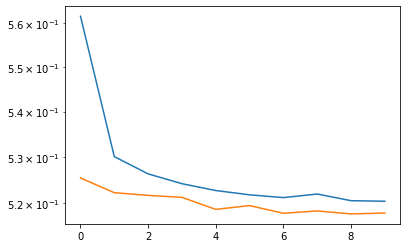

In [213]:
plt.plot(chargenet.model.history.history['loss'])
plt.plot(chargenet.model.history.history['val_loss'])
plt.gca().set_yscale('log')
plt.show()

chargenet.llh = tf.keras.models.clone_model(chargenet.model)
chargenet.llh.set_weights(chargenet.model.get_weights())
chargenet.llh.layers[-1].activation = tf.keras.activations.linear
chargenet.llh.compile()

# some nasty gymnastics to get the NN inputs for the grid scan
#chargenet.tt = np.vstack([g.get_array('x', flat=True), g.get_array('b', flat=True), np.ones(np.prod(g.shape)) * example_N_src]).T
#chargenet.tts = np.repeat(chargenet.tt, len(toy_experiment.detector_xs), axis=0)

#chargenet.xxs = np.repeat(test_event[0][np.newaxis,:, :], np.prod(g.shape), axis=0)
#chargenet.xxs = chargenet.xxs.reshape(-1, 3)

#chargenet.llhs = chargenet.llh.predict([chargenet.xxs, chargenet.tts])

#g['charge_llh'] = -np.sum(chargenet.llhs.reshape(-1, len(toy_experiment.detector_xs)), axis=1).reshape(g.shape)
#g['charge_llh'] -= np.min(g['charge_llh'])

#fig, ax = plt.subplots(1, 3, figsize=(20,5))
#plt.subplots_adjust(wspace=0.3)

#plot_diff(g['dom_charge_terms'], g['charge_llh'], title_a='Analytic', title_b='NN', vmax=20, axes=ax)
#plot_truth(ax, example_x_src, example_b_src)

In [215]:
grid_spacing = 100


xs = np.linspace(-5.5, 5.5, grid_spacing)
bs = np.linspace(-2, 2, grid_spacing)

mg = np.meshgrid(xs,bs)

chargenet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten(),np.ones(grid_spacing**2)*N_toy]).T
chargenet.grid_t = np.repeat(chargenet.grid_t,N_det,axis=0)

chargenet.grid_x = np.tile(ev[0],grid_spacing**2)#.reshape((-1,N_det))
chargenet.grid_x = np.vstack((chargenet.grid_x,np.tile(detector_loc(N_det),grid_spacing**2))).T

chargenet.grid_llh = chargenet.llh.predict([chargenet.grid_x,chargenet.grid_t])

In [199]:
def plot_NN_scan(llh_scan_res, xs, ys, true_x, true_y, axis_labels, title, vmax):
    # copy to avoid modifying original scan results
    scan = np.copy(llh_scan_res)
    
    gridsize = len(xs)
    
    fig,ax = plt.subplots()
    
    m = ax.pcolormesh(xs, ys, scan, 
                          cmap='Spectral', rasterized=True, linewidth=0, vmin=0, vmax=vmax)
        
    ax.plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
        
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    ax.set_title(title)
    colorbar(m)

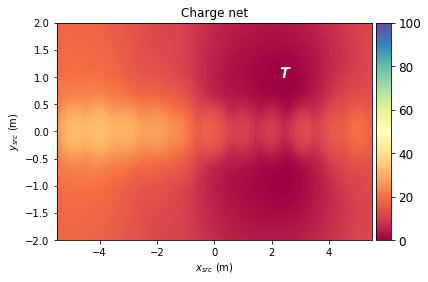

In [216]:
NN_pos_scan_res = -np.sum(chargenet.grid_llh.reshape(-1, N_det), axis=1).reshape(grid_spacing,grid_spacing)
#NN_pos_scan_res = -1*chargenet.grid_llh.reshape(grid_spacing,grid_spacing)
NN_pos_scan_res -= np.min(NN_pos_scan_res)

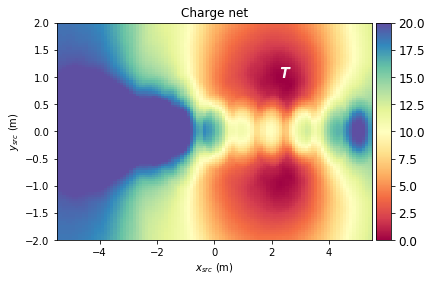

In [217]:
plot_NN_scan(NN_pos_scan_res, xs, bs, x_toy, b_toy,
                   axis_labels=['$x_{src}$ (m)', '$y_{src}$ (m)'], title='Charge net', vmax=20)

In [ ]:
hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.x, hitnet.t, test_size=0.2, random_state=42)

hitnet.d_train = get_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = get_dataset(hitnet.x_test, hitnet.t_test, test=True)

class trafo(tf.keras.layers.Layer):
    c = 0.3
    def call(self, hits, theta):
        r2 = tf.math.square(theta[:,0] - hits[:,1]) + tf.math.square(theta[:,1])
        r = tf.math.sqrt(r2)
        
        delta_t = hits[:,0] - r/self.c 
        
        out = tf.stack([
                 hits[:,0],
                 hits[:,1],
                 hits[:,2],
                 r,
                 delta_t,
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )    
        return out
hitnet.trafo = trafo

activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(128, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(64, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

hist = hitnet.model.fit(hitnet.d_train, epochs=4, verbose=1, validation_data=hitnet.d_test)

plt.plot(hitnet.model.history.history['loss'])
plt.plot(hitnet.model.history.history['val_loss'])
plt.gca().set_yscale('log')

hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear
hitnet.llh.compile()

# some nasty gymnastics to get the NN inputs for the grid scan
hitnet.tt = np.vstack([g.get_array('x', flat=True), g.get_array('b', flat=True), np.ones(np.prod(g.shape)) * example_N_src]).T
hitnet.tts = np.repeat(hitnet.tt, test_event[1].shape[0], axis=0)
hitnet.xxs = np.repeat(test_event[1][np.newaxis,:, :], np.prod(g.shape), axis=0)
hitnet.xxs = hitnet.xxs.reshape(-1, 3)

hitnet.llhs = hitnet.llh.predict([hitnet.xxs, hitnet.tts])

g['hit_llh'] = -np.sum(hitnet.llhs.reshape(-1, test_event[1].shape[0]), axis=1).reshape(g.shape)
g['hit_llh'] -= np.min(g['hit_llh'])

fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

plot_diff(g['dom_hit_term'], g['hit_llh'], title_a='Analytic', title_b='NN', vmax=20, axes=ax)
plot_truth(ax, example_x_src, example_b_src)



g['llh'] = g['dom_llh'] + g['hit_llh']
g['llh'] -= np.min(g['llh'])





fig, ax = plt.subplots(3, 3, figsize=(20,18))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Zoom in
#grid_to_plot = g[example_x_src-0.5:example_x_src+0.5, example_b_src-0.5:example_b_src+0.5]

grid_to_plot = g

plot_diff(grid_to_plot['dom_hit_term'], grid_to_plot['hit_llh'], title_a='Hit Analytic', title_b='Hit NN', vmax=20, axes=ax[0])
plot_diff(grid_to_plot['dom_charge_terms'], grid_to_plot['charge_llh'], title_a='Charge Analytic', title_b='Charge NN', vmax=20, axes=ax[1])
plot_diff(grid_to_plot['dom_llh'], grid_to_plot['llh'], title_a='Analytic', title_b='NN', vmax=20, axes=ax[2])

plot_truth(ax, example_x_src, example_b_src)

